In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb  
import matplotlib.pyplot as plt

In [8]:
""" Read Data and create the train, validation and test sets """


train_data = pd.read_csv("regression-tabular-california-housing/train.csv", header= 0, index_col=0)
train_data["RegVal"] = train_data["MedHouseVal"]
train_data = train_data.drop(columns = ["MedHouseVal"])

test_data = pd.read_csv("regression-tabular-california-housing/test.csv", header= 0, index_col= 0)

X = train_data.drop(columns=["RegVal"])
y = train_data["RegVal"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# creating dmatrix for train, test and validation test
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest= xgb.DMatrix(test_data)


CAP = float(train_data["RegVal"].max())
FLOOR = float(train_data["RegVal"].min())

# your hyperparameters (set as you like)
lambda_cap = y.count()/y[y==CAP].count() * 0.20
lambda_floor = y.count()/y[y==FLOOR].count() * 0
print(lambda_cap)
print(lambda_floor)

4.065353037766831
0.0


In [9]:
def capped_mse_obj_exact(preds, dtrain):
    """
    Exact gradient and hessian derived from:
      L = (y - p)^2 + lambda_cap * I[y==CAP] * (CAP - p)^2
                       + lambda_floor * I[y==FLOOR] * (FLOOR - p)^2
    preds: 1d array of predictions (y_hat)
    returns: grad, hess (1d arrays)
    """
    y = dtrain.get_label()
    p = preds.flatten().astype(np.float64)

    # Base MSE grad/hess
    grad = 2.0 * (p - y)                 # vector
    hess = np.full_like(p, 2.0, dtype=np.float64)

    # boolean masks (use isclose for float safety)
    cap_mask = np.isclose(y, CAP)
    floor_mask = np.isclose(y, FLOOR)

    if np.any(cap_mask):
        # add contribution from lambda_cap * (CAP - p)^2
        grad[cap_mask] += 2.0 * lambda_cap * (p[cap_mask] - CAP)
        hess[cap_mask] += 2.0 * lambda_cap

    if np.any(floor_mask):
        grad[floor_mask] += 2.0 * lambda_floor * (p[floor_mask] - FLOOR)
        hess[floor_mask] += 2.0 * lambda_floor

    return grad, hess


In [10]:

# Define Parameters for REGRESSION
params = {
    # --- TASK SPECIFICATION ---
    'eval_metric': 'rmse',            # Evaluation metric: rmse, mae, rmsle
    'seed':5,
    
    # --- CORE BOOSTING PARAMETERS ---
    'booster': 'gbtree',              # Type of model: gbtree, gblinear, dart
    # 'eta': 0.0001,                       # Learning rate (shrinkage)
    'gamma': 0.00001,                       # Minimum loss reduction to make a split
    'max_depth': 9,                   # Maximum tree depth
    'min_child_weight': .08,            # Minimum sum of instance weight needed in a child
    'grow_policy': 'lossguide',
    'max_bin': 1024,
    
    # --- SUBSAMPLING PARAMETERS ---
    'subsample': 0.8,                 # of training instances to sample per tree
    'colsample_bytree': 0.8,          # of features to sample per tree
    'colsample_bylevel': 1,           # of features to sample per tree level
    'colsample_bynode': 1,            # of features to sample per tree node
    
    # --- REGULARIZATION PARAMETERS ---
    'reg_alpha': 0.1,                   # L1 regularization (LASSO)
    'reg_lambda': 1,                  # L2 regularization (Ridge)
    
    # --- MISCELLANEOUS ---
    'random_state': 42,               # Seed for reproducibility
    'nthread': 8,                     # Number of parallel threads
    'verbosity': 2                    # 0 (silent), 1 (warning), 2 (info), 3 (debug)
}
class GeometricLRSchedule:
    def __init__(self, lr_start, lr_end, total_steps):
        super().__init__()
        self.lr_start = lr_start
        self.lr_end = lr_end
        self.total_steps = total_steps
        # compute geometric ratio
        self.r = (lr_end / lr_start) ** (1 / (total_steps - 1))

    def __call__(self, step):
        lr = max ( self.lr_start * (self.r ** step),  self.lr_end) # dont decrease below minimum
        if step % 500==0: print(f"LR at step: {step}: {lr}")
        return lr

total_steps = 50000
lr_schedule = GeometricLRSchedule(0.0005,0.00008,total_steps)
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500000,
    obj=capped_mse_obj_exact,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=500,
    verbose_eval=100,
    callbacks=[xgb.callback.LearningRateScheduler(lr_schedule)]

)

# Evaluate the model using regression metrics in validation 
val_pred = model.predict(dval)
print(f'RMSE: {mean_squared_error(y_val, val_pred, squared=False)}')
print(f'MAE: {mean_absolute_error(y_val, val_pred)}')
print(f'R²: {r2_score(y_val, val_pred)}')



[0]	train-rmse:1.40981	val-rmse:1.43384
LR at step: 0: 0.0005
[100]	train-rmse:1.34815	val-rmse:1.37418
[200]	train-rmse:1.29015	val-rmse:1.31830
[300]	train-rmse:1.23547	val-rmse:1.26582
[400]	train-rmse:1.18410	val-rmse:1.21670


KeyboardInterrupt: 

In [ ]:
# Evaluate on Test Set
test_pred = model.predict(dtest)
test_pred[test_pred >= CAP] = CAP
test_pred[test_pred <= FLOOR] = FLOOR

submission_df = pd.DataFrame(data={"id":test_data.index, "MedHouseVal":test_pred})
submission_df.to_csv("regression-tabular-california-housing/xg_boost_submission.csv", index=False)


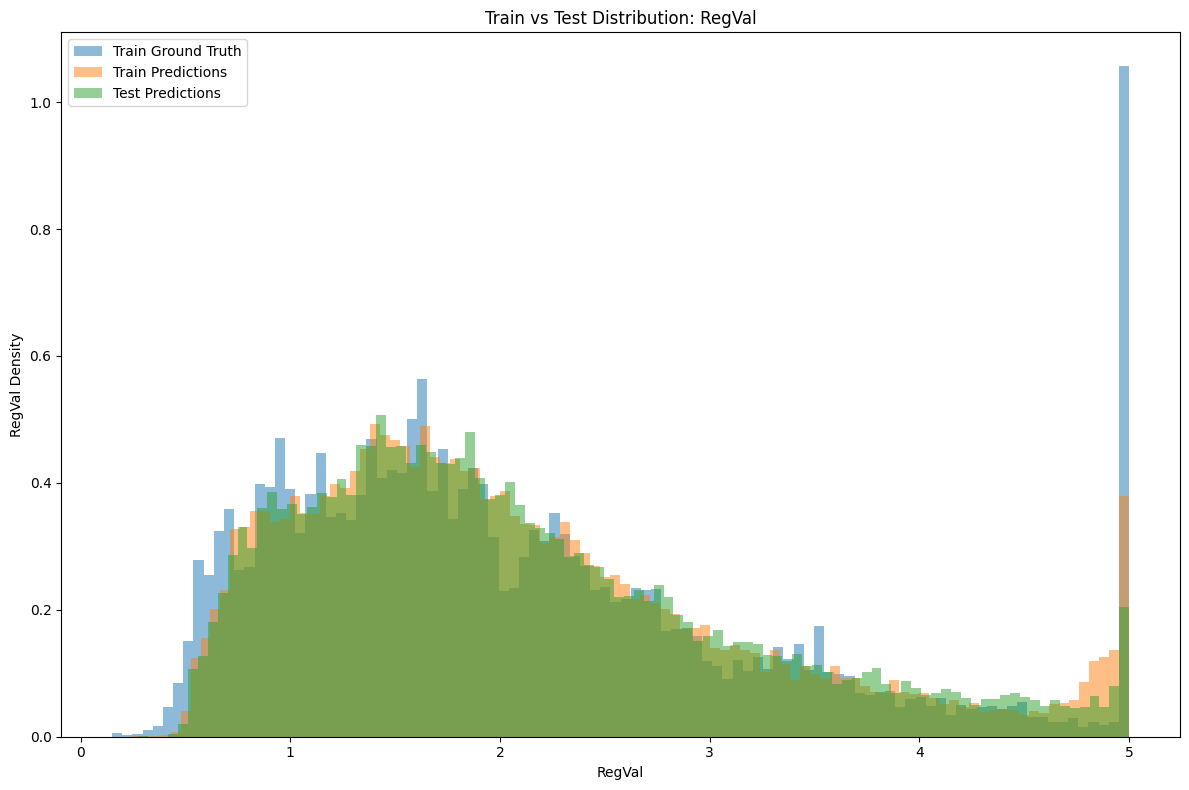

In [ ]:
""" histogram the train_ground_truth, train_pred, and test_pred """

# relabel y_train and train_pred to include the entire training + validation set
y_train = y
dtrain  = xgb.DMatrix(X, label=y)
train_pred = model.predict(dtrain)
train_pred[train_pred>=CAP] = CAP 
train_pred[train_pred<=FLOOR] = FLOOR 

plt.figure(figsize=(12, 8))
plt.hist(y_train, bins=100, alpha=0.5, label="Train Ground Truth", density=True)
plt.hist(train_pred, bins=100, alpha=0.5, label="Train Predictions", density=True)
plt.hist(test_pred, bins=100, alpha=0.5, label="Test Predictions", density=True)
plt.title(f"Train vs Test Distribution: RegVal")
plt.xlabel("RegVal")
plt.ylabel(f"RegVal Density")
plt.legend()
plt.tight_layout()